In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import seaborn as sns
from intercluster.plotting import *

%load_ext autoreload
%autoreload 2

In [ ]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this aside from font.size
# To get tex working on linux run the following:
# `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 32
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

#subset_colors = [cmap(1), cmap(5), cmap(3), cmap(6), cmap(7), cmap(0), cmap(2)]
#cmap_subset = ListedColormap(subset_colors)

#distortion_colors = [cmap(5), cmap(1), cmap(3), cmap(6), cmap(7), cmap(0)]
#distortion_cmap = ListedColormap(distortion_colors)

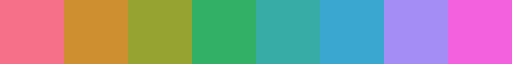

In [27]:
cmap

In [55]:
color_dict = {
    'KMeans' : 'k',
    'DBSCAN' : 'k',
    'Decision-Tree' : cmap(5),
    'Removal-Tree' : cmap(6),
    'ExKMC' : cmap(0),
    'Decision-Set-Clustering' : cmap(3)
}

linestyle_dict = {
    'KMeans' : 'solid',
    'DBSCAN' : 'dashed',
    'Decision-Tree' : 'solid',
    'Removal-Tree' : 'solid',
    'ExKMC' : 'solid',
    'Decision-Set-Clustering' : 'solid'
}

# Experiment Plotting:
The following is what we use to gather computed information and produce plots/tables. Note that 
our distribution plots are more reliant upon having the data readily available, and 
are therefore plotted as a part of the `interpretable_measurements.py` and `explanation_tree.py`
files. 

In [4]:
# Specify a dataset
dataset = 'climate'

### Max Rules Experiments

In [58]:
# Load experiment results
fname = "../data/experiments/" + dataset + "/max_rules/exp_kmeans.csv"
experiment_df = pd.read_csv(fname, header=[0, 1, 2], index_col=0)

# Computes statistics:
grouped = experiment_df.T.groupby(level = [0,1])
mean_df = grouped.mean().T
std_df = grouped.std().T

In [59]:
mean_df

Coverage-Mistake-Score                                           \
   Decision-Set-Clustering Decision-Tree  ExKMC KMeans Removal-Tree   
0                   257.84        -116.0   -6.0  344.0        -15.8   
1                   272.45          -6.0   34.0  344.0        -15.2   
2                   282.49          94.0   44.0  344.0        -16.8   
3                   291.25         124.0   84.0  344.0        -15.6   
4                   298.50         154.0  114.0  344.0        -17.8   
5                   305.65         184.0  124.0  344.0        -17.2   
6                   311.31         204.0  154.0  344.0        -15.8   
7                   316.66         224.0  184.0  344.0        -17.4   
8                   320.99         254.0  204.0  344.0        -18.6   
9                   324.34         254.0  224.0  344.0        -17.0   
10                  327.96         264.0  234.0  344.0        -15.6   
11                  330.53         274.0  254.0  344.0        -16.0   
12                  332.78         284.0  264.0  344.0        -16.0   
13                  335.04         304.0  274.0  344.0        -16.2   

          Silhouette-Score                                                 \
   Decision-Set-Clustering Decision-Tree     ExKMC    KMeans Removal-Tree   
0                 0.277424      0.168218  0.199004  0.219858     0.188523   
1                 0.269459      0.178893  0.203423  0.219858     0.188471   
2                 0.263930      0.192961  0.205540  0.219858     0.187789   
3                 0.258080      0.198565  0.204797  0.219858     0.188317   
4                 0.254024      0.203507  0.206739  0.219858     0.186700   
5                 0.249093      0.207902  0.209296  0.219858     0.187315   
6                 0.244420      0.208533  0.211147  0.219858     0.188454   
7                 0.241598      0.208533  0.213123  0.219858     0.187244   
8                 0.237762      0.210440  0.213305  0.219858     0.186222   
9                 0.235683      0.210440  0.216052  0.219858     0.187446   
10                0.232519      0.209958  0.217137  0.219858     0.188584   
11                0.230744      0.210964  0.217078  0.219858     0.188033   
12                0.228819      0.212227  0.218573  0.219858     0.188220   
13                0.227157      0.211838  0.219162  0.219858     0.188079   

           max-rule-length                                          \
   Decision-Set-Clustering Decision-Tree ExKMC KMeans Removal-Tree   
0                      0.0           3.0   5.0    NaN          5.0   
1                      0.0           4.0   5.0    NaN          5.0   
2                      0.0           5.0   5.0    NaN          5.0   
3                      0.0           5.0   6.0    NaN          5.0   
4                      0.0           5.0   6.0    NaN          5.0   
5                      0.0           5.0   6.0    NaN          5.0   
6                      0.0           5.0   6.0    NaN          5.0   
7                      0.0           6.0   6.0    NaN          5.0   
8                      0.0           6.0   6.0    NaN          5.0   
9                      0.0           6.0   7.0    NaN          5.0   
10                     0.0           7.0   7.0    NaN          5.0   
11                     0.0           7.0   8.0    NaN          5.0   
12                     0.0           7.0   8.0    NaN          5.0   
13                     0.0           7.0   9.0    NaN          5.0   

   weighted-average-rule-length                                              
        Decision-Set-Clustering Decision-Tree     ExKMC KMeans Removal-Tree  
0                      3.115708      2.735465  3.645349    NaN     3.584275  
1                      3.108464      3.116279  3.845930    NaN     3.583772  
2                      3.133353      3.436047  4.011628    NaN     3.585114  
3                      3.114718      3.575581  4.319767    NaN     3.584107  
4                      3.149206      3.706395

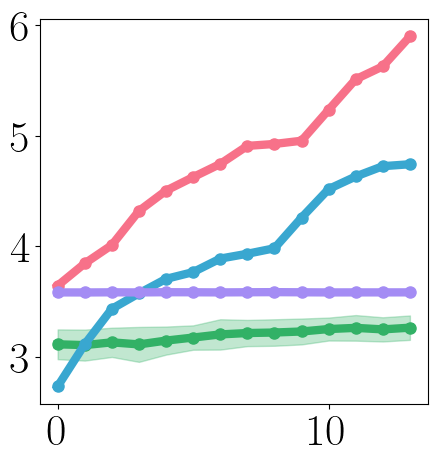

In [64]:
measurement = 'weighted-average-rule-length'
xaxis = True
yaxis = True

measurement_mean_df = mean_df[measurement]
measurement_std_df = std_df[measurement]

# Plot results
fig,ax = plt.subplots(1,1,figsize=(5,5))

for method in measurement_mean_df.columns:
    if measurement_mean_df[method].isnull().all():
        continue
    elif measurement_mean_df[method].nunique() == 1:
        ax.hlines(
            y = measurement_mean_df[method].iloc[0],
            xmin = measurement_mean_df.index.min(),
            xmax = measurement_mean_df.index.max(),
            color = color_dict[method],
            alpha = 0.6,
            label = method,
            linewidth = 3,
            linestyle = linestyle_dict[method]
        )
    else:
        ax.plot(
            measurement_mean_df.index,
            measurement_mean_df[method], 
            color = color_dict[method],
            label = method,
            linewidth = 6,
            marker='o',
            markersize = 8,
        )
        ax.fill_between(
            measurement_mean_df.index, 
            measurement_mean_df[method] - measurement_std_df[method],
            measurement_mean_df[method] + measurement_std_df[method],
            color= color_dict[method],
            alpha=0.3
        )


if not xaxis:
    plt.xticks([])
if not yaxis:
    plt.yticks([])
    

(0.0, 1.0, 0.0, 1.0)

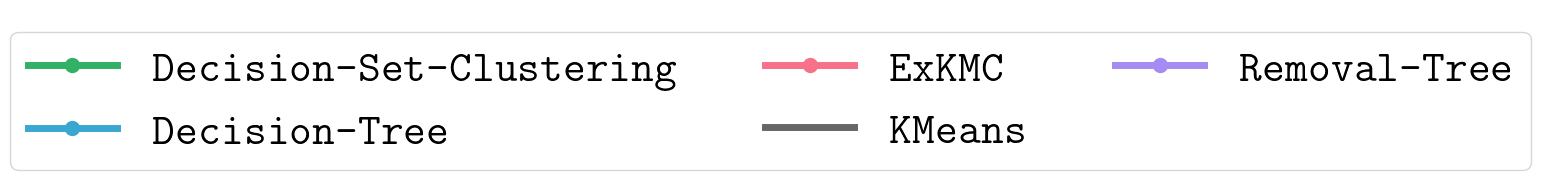

In [62]:
# Legend:
fig, ax = plt.subplots(figsize = (6,1))

legend_elements = []
for method in measurement_mean_df.columns:
    if measurement_mean_df[method].nunique() == 1:
        legend_elements += [
            mlines.Line2D(
                [], [],
                color=color_dict[method],
                lw=5,
                linestyle = linestyle_dict[method],
                label=rf"\texttt{{{method}}}",
                alpha=0.6
            )
        ]
    else:
        legend_elements += [
            mlines.Line2D(
                [], [],
                marker = 'o',
                markersize=10,
                color=color_dict[method],
                lw=5,
                label=rf"\texttt{{{method}}}",
                alpha=1
            )
        ]

ax.legend(handles=legend_elements, ncol=3)
ax.axis('off')

### Older experiments

In [16]:
# Colors and Modules for plotting:
colormap = distortion_cmap
baseline_list = ['KMeans-Full', 'IMM-Full']

# This is just a list of column names to look up in the dataframe
module_list = ['IMM', 'IMM-outliers', 'Forest-Depth-2', 
               'Forest-Depth-3','Forest-Depth-4']

# And these are their corresponding latex versions
legend_module_list = [r'\texttt{IMM}', r'\texttt{IMM-outliers}', r'\texttt{Forest-Depth-2}', 
               r'\texttt{Forest-Depth-3}',r'\texttt{Forest-Depth-4}']

# We give colors to each as follows
color_dict = {mod : i for i,mod in enumerate(module_list)}

In [17]:
# Specify the model:
model = 'Forest-Depth-2'

# And then we'll compute ratios for clustering costs:
measure = 'normalized-clustering-cost'
xlabel = 'minimum coverage'
ylabel = 'distortion'

# Uncomment here to save:
#fname = '../figures/relative_coverage/' + ylabel + '/' + dataset + '/' + model + '.png'
fname = None

xaxis = False
if dataset == 'fashion':
    xaxis = True

yaxis = False
if model == 'IMM-outliers':
    yaxis = True

if not xaxis:
    xlabel = ''
if not yaxis:
    ylabel = ''

# Compute distortion with cost ratios:
cost_df = experiment_df[measure][model]

# Divide by the reference:
distortion_df = cost_df[[model, 'IMM', 'KMeans']].div(cost_df['KMeans'], level=1)

# Find the mean and standard deviation
plot_df = distortion_df.groupby(level=0, axis=1).mean()
plot_std_df = distortion_df.groupby(level=0, axis=1).std()

# More plotting info:
plot_colors = [colormap(color_dict[mod]) for mod in plot_df.columns if mod != 'KMeans']
plot_cmap = ListedColormap(plot_colors)
domain_array = np.array([list(np.linspace(0.5,1,11))] * len(plot_df.columns)).T
domain_df = pd.DataFrame(domain_array, columns = plot_df.columns)

xlim = (0.49, 1.01)
#ylim = (plot_df.min().min() - 0.05, plot_df.max().max() + 0.05)

if dataset == 'climate':
    ylim = (0.95, 1.1)
elif dataset == 'anuran':
    ylim = (0.95, 1.7)
elif dataset == 'covertype':
    ylim = (0.95, 1.4)
elif dataset == 'digits':
    ylim = (0.95, 1.7)
elif dataset == 'mnist':
    ylim = (0.95, 1.25)
elif dataset == 'fashion':
    ylim = (0.95, 1.4)

experiment_plotter(
    plot_df,
    plot_std_df,
    domain_df,
    xlabel = xlabel,
    ylabel = ylabel,
    cmap = plot_cmap,
    baseline_list = ['KMeans'],
    legend = False,
    xlim = xlim,
    ylim = ylim,
    xaxis = xaxis,
    yaxis = yaxis,
    filename = fname,
)

KeyError: 'normalized-clustering-cost'

(0.0, 1.0, 0.0, 1.0)

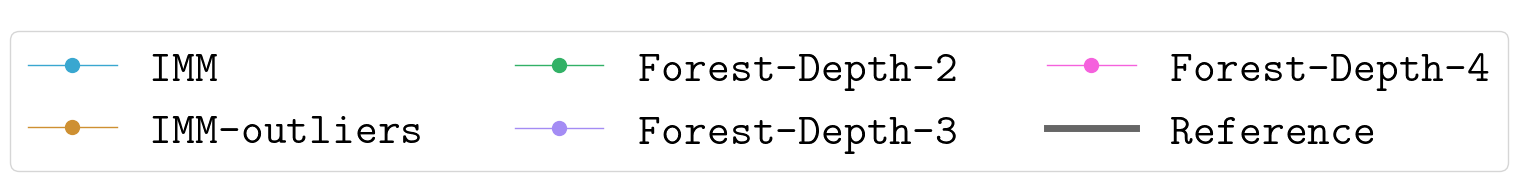

In [ ]:
# Legend:
fig, ax = plt.subplots(figsize = (6,1))
legend_elements = [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=10,
        color=colormap(i),
        lw=1,
        label=mod,
        alpha=1
    )
    for i,mod in enumerate(legend_module_list)
]

legend_elements += [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=0,
        color='k',
        lw=5,
        linestyle = '-',
        label=r"\texttt{Reference}",
        alpha=0.6
    )
]

ax.legend(handles=legend_elements, ncol=3)
ax.axis('off')
#plt.savefig('../figures/relative_coverage/distortion_legend.png', bbox_inches = 'tight', dpi = 300)

### Interpretable Measurements:

In [27]:
# Interpretable Measurements Table
fname = "../data/experiments/" + dataset + "/measurements.csv"
inter_measures_df = pd.read_csv(fname, index_col=0)
inter_measures_df

,coverage,max-rule-length,normalized-clustering-cost,overlap,weighted-average-rule-length
Row,,,,,
forest_depth_2,0.819086,2.0,35.508812,1.160737,2.000000
forest_depth_3,0.809543,3.0,33.223462,1.113150,3.000000
forest_depth_4,0.835143,4.0,32.328097,1.075334,3.627513
forest_depth_imm,0.823486,7.0,32.266952,1.083755,3.802600
imm,1.000000,7.0,39.302320,1.000000,5.052857
outlier,0.800057,6.0,36.508056,1.000000,4.946861


In [28]:
# Additional Results for explanation tree
fname = "../data/experiments/" + dataset + "/explanation_tree.csv"
explanation_tree_df = pd.read_csv(fname, index_col=0)
explanation_tree_df

,normalized-clustering-cost,overlap,coverage,max-rule-legnth,weighted-average-rule-length
0,29.855588,1.0,0.715771,7,5.109452
